非配对图像翻译，比如性别转换、人脸转换等

CycleGAN不需要严格配对的图片，只需要两类（domain）即可，例如一个文件夹都是苹果图片，另一个文件夹都是橘子图片。使用A和B两类图片，就可以实现A到B的翻译和B到A的翻译。
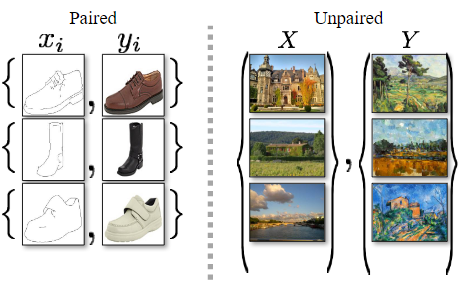

https://github.com/junyanz/CycleGAN pytorch论文实现

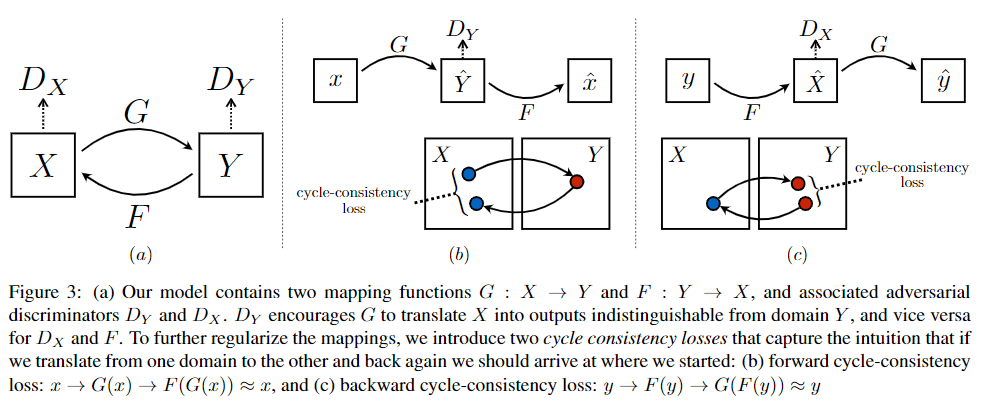

CycleGAN由两个生成器 G 和 F ，以及两个判别器 Dx 和 Dy 组成。通过一致性损失，约束经过domain变换后的数据之间的误差。

$$
\begin{array}{l}{L_{G A N}\left(G, D_{Y}, X, Y\right)=\mathbb{E}_{y \sim p_{y}}\left[\log D_{Y}(y)\right]+\mathbb{E}_{x \sim p_{x}}\left[\log \left(1-D_{Y}(G(x))\right)\right]} \\ {L_{G A N}\left(F, D_{X}, Y, X\right)=\mathbb{E}_{x \sim p_{x}}\left[\log D_{X}(x)\right]+\mathbb{E}_{y \sim p_{y}}\left[\log \left(1-D_{X}(F(y))\right)\right]}\end{array}
$$

Cycle Consistency Loss：
$$
L_{c y c}(G, F)=\mathbb{E}_{x \sim p_{x}}\left[\|F(G(x))-x\|_{1}\right]+\mathbb{E}_{y \sim p_{y}}\left[\|G(F(y))-y\|_{1}\right]
$$

总损失：
$$
L\left(G, F, D_{X}, D_{Y}\right)=L_{G A N}\left(G, D_{Y}, X, Y\right)+L_{G A N}\left(F, D_{X}, Y, X\right)+\lambda L_{c y c}(G, F)
$$

论文实现中的tricks：
- 使用Least-Square Loss而没有用cross entropy损失
- discriminator并不是，对每一张输入G（x）都立刻进行pair（真，假）的判别。而是先维护一个G（x）生成的Y假，的集合。然后random choice y假，与y真domain中抽取的y真进行损失计算。    提升模型转化的平均能力，提高训练稳定性。

Model 网络结构

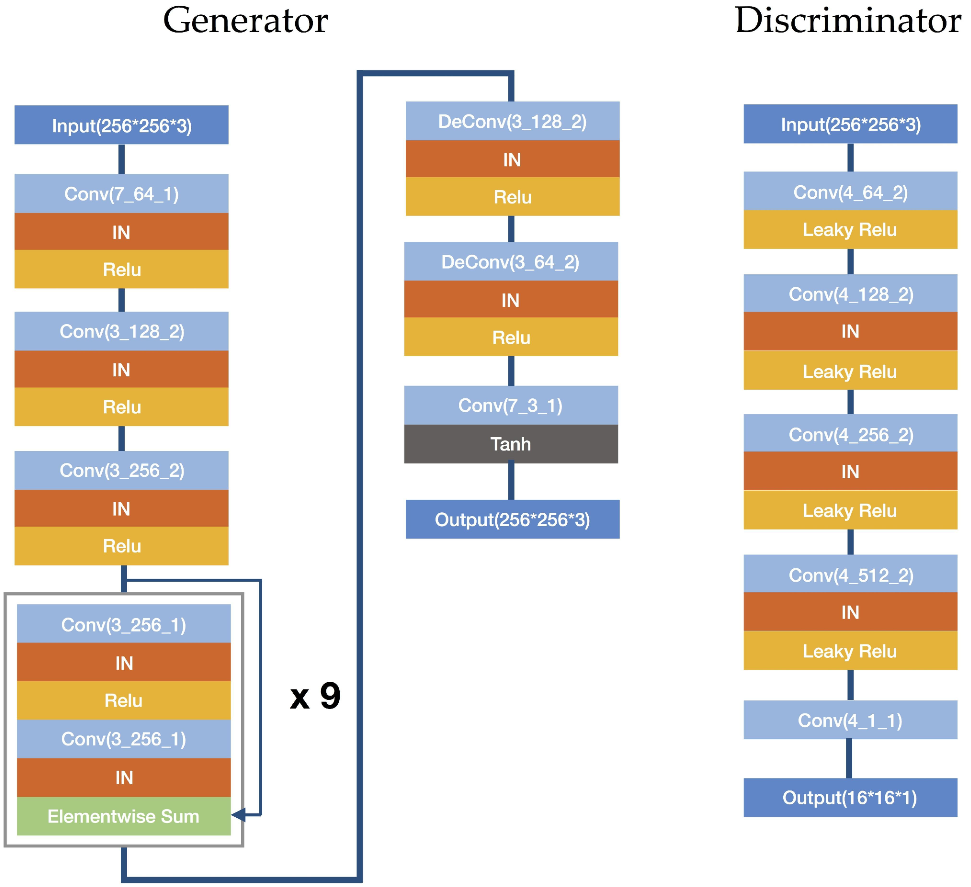

使用instant norm，只对某一个输入样本进行norm

### 模型使用示例

#### 性别转换

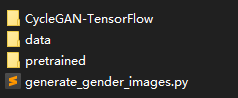

在gender文件夹下：

1. generate_gender_images.py: 处理男女图片数据到不同文件夹下
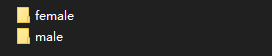

2. 使用build_data.py将图片转换成tfrecords格式

In [ ]:
! python CycleGAN-TensorFlow/build_data.py --X_input_dir data/male/ --Y_input_dir data/female/ --X_output_file data/male.tfrecords --Y_output_file data/female.tfrecords

3. 使用train.py训练CycleGAN模型

In [ ]:
! python CycleGAN-TensorFlow/train.py --X data/male.tfrecords --Y data/female.tfrecords --image_size 256

4. 使用export_graph.py将模型打包成.pb文件，生成的文件在pretrained文件夹中

In [ ]:
! python CycleGAN-TensorFlow/export_graph.py --checkpoint_dir checkpoints/path/ --XtoY_model male2female.pb --YtoX_model female2male.pb --image_size 256


5. 通过inference.py使用模型处理单张图片

In [ ]:
python CycleGAN-TensorFlow/inference.py --model pretrained/male2female.pb --input xx.jpg --output xxx.jpg --image_size 256
python CycleGAN-TensorFlow/inference.py --model pretrained/female2male.pb --input xx.jpg --output xxx.jpg --image_size 256

6. 处理多张图片inference_multi.py

In [ ]:
# 注意在CycleGAN-TensorFlow文件夹下运行
import tensorflow as tf
import numpy as np
from model import CycleGAN
from imageio import imread, imsave
import glob
import os

# 中间输出文件
image_file = 'face.jpg'
W = 256
# 4行5列
result = np.zeros((4 * W, 5 * W, 3))

for gender in ['male', 'female']:
    if gender == 'male':
        images = glob.glob('../data/male/*.jpg')
        model = '../pretrained/male2female.pb'
        r = 0  # 前两行：一行male原始，一行转换后male
    else:
        images = glob.glob('../data/female/*.jpg')
        model = '../pretrained/female2male.pb'
        r = 2  # 后两行：一行female原始，一行转换后female

    graph = tf.Graph()
    with graph.as_default():
        graph_def = tf.GraphDef()
        with tf.gfile.FastGFile(model, 'rb') as model_file:
            graph_def.ParseFromString(model_file.read())
            tf.import_graph_def(graph_def, name='')

        with tf.Session(graph=graph) as sess:
            input_tensor = graph.get_tensor_by_name('input_image:0')
            output_tensor = graph.get_tensor_by_name('output_image:0')

            for i, image in enumerate(images):
                image = imread(image)
                # 此时output是一个字符串
                output = sess.run(output_tensor, feed_dict={input_tensor: image})

                with open(image_file, 'wb') as f:
                    f.write(output)

                # 此时output是一个nparray
                output = imread(image_file)
                maxv = np.max(output)
                minv = np.min(output)
                output = ((output - minv) / (maxv - minv) * 255).astype(np.uint8)

                # 前两行：一行male原始，一行转换后male
                # 后两行：一行female原始，一行转换后female
                result[r * W: (r + 1) * W, i * W: (i + 1) * W, :] = image
                result[(r + 1) * W: (r + 2) * W, i * W: (i + 1) * W, :] = output

os.remove(image_file)
imsave('CycleGAN_result.jpg', result)

#### 视频性别转换

检测出人脸的性别和年龄，模型https://github.com/yu4u/age-gender-estimation

文件夹video_gender\age-gender-estimation下，gender_age_detect_guide.py是结合dlib，实时检测的使用方法

视频文件存放在video_gender\data文件夹下
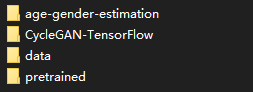

1. 在video_gender\age-gender-estimation文件夹下运行age_detect.py

In [ ]:
from wide_resnet import WideResNet
import numpy as np
import cv2
import dlib
import pickle

depth = 16
width = 8
img_size = 64
model = WideResNet(img_size, depth=depth, k=width)()
model.load_weights('weights.hdf5')

detector = dlib.get_frontal_face_detector()
cap = cv2.VideoCapture('../data/video.mp4')

pos = []
frame_id = -1

while cap.isOpened():
    ret, image_np = cap.read()
    frame_id += 1
    if len((np.array(image_np)).shape) == 0:
        break

    image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
    img_h = image_np.shape[0]
    img_w = image_np.shape[1]
    detected = detector(image_np, 1)

    if len(detected) > 0:
        for d in detected:
            x0, y0, x1, y1, w, h = d.left(), d.top(), d.right(), d.bottom(), d.width(), d.height()
            x0 = max(int(x0 - 0.25 * w), 0)
            y0 = max(int(y0 - 0.45 * h), 0)
            x1 = min(int(x1 + 0.25 * w), img_w - 1)
            y1 = min(int(y1 + 0.05 * h), img_h - 1)
            w = x1 - x0
            h = y1 - y0
            if w > h:
                x0 = x0 + w // 2 - h // 2
                w = h
                x1 = x0 + w
            else:
                y0 = y0 + h // 2 - w // 2
                h = w
                y1 = y0 + h
            
            face = cv2.resize(image_np[y0: y1, x0: x1, :], (img_size, img_size))
            result = model.predict(np.array([face]))
            # 只取性别
            pred_gender = result[0][0][0]

            if pred_gender > 0.5:
                # frame_id，位置，大小，性别
                pos.append([frame_id, y0, y1, x0, x1, h, w, 'F'])
            else:
                pos.append([frame_id, y0, y1, x0, x1, h, w, 'M'])

print(frame_id + 1, len(pos))

with open('../data/pos.pkl', 'wb') as fw:
    pickle.dump(pos, fw)
    
cap.release()
cv2.destroyAllWindows()

In [ ]:
! python age_detect.py

2. CycleGAN转换，结果写入新的视频文件：video_gender\CycleGAN-TensorFlow文件夹下在运行inference_video.py

In [ ]:
import tensorflow as tf
import numpy as np
from model import CycleGAN
from imageio import imread
import os
import cv2
import pickle
from tqdm import tqdm

with open('../data/pos.pkl', 'rb') as fr:
    pos = pickle.load(fr)

cap = cv2.VideoCapture('../data/video.mp4')
ret, image_np = cap.read()
# 输出video
out = cv2.VideoWriter('../data/output.mp4', -1, cap.get(cv2.CAP_PROP_FPS), (image_np.shape[1], image_np.shape[0]))

# 读取frames
frames = []
while cap.isOpened():
    ret, image_np = cap.read()
    if len((np.array(image_np)).shape) == 0:
        break
    frames.append(cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB))

image_size = 256
image_file = 'face.jpg'
for gender in ['M', 'F']:
    if gender == 'M':
        model = '../pretrained/male2female.pb'
    else:
        model = '../pretrained/female2male.pb'

    graph = tf.Graph()
    with graph.as_default():
        graph_def = tf.GraphDef()
        with tf.gfile.FastGFile(model, 'rb') as model_file:
            graph_def.ParseFromString(model_file.read())
            tf.import_graph_def(graph_def, name='')

        with tf.Session(graph=graph) as sess:
            input_tensor = graph.get_tensor_by_name('input_image:0')
            output_tensor = graph.get_tensor_by_name('output_image:0')

        for i in tqdm(range(len(pos))):
            # 根据frame id处理每一帧有人脸图片
            fid, y0, y1, x0, x1, h, w, g = pos[i]
            if g == gender:
                face = cv2.resize(frames[fid - 1][y0: y1, x0: x1, :], (image_size, image_size))
                # 此时output是一个字符串
                output_face = sess.run(output_tensor, feed_dict={input_tensor: face})

                with open(image_file, 'wb') as f:
                    f.write(output_face)

                # 此时output是一个nparray
                output_face = imread(image_file)
                maxv = np.max(output_face)
                minv = np.min(output_face)
                output_face = ((output_face - minv) / (maxv - minv) * 255).astype(np.uint8)

                output_face = cv2.resize(output_face, (w, h))
                frames[fid - 1][y0: y1, x0: x1, :] = output_face

# 输出到out video
for frame in frames:
    out.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
            
os.remove(image_file)
cap.release()
out.release()
cv2.destroyAllWindows()

3. 视频文件写入声音

In [ ]:
# http://www.ffmpeg.org/download.html
# 从原始视频中提取音频
! ffmpeg -i video.mp4 -f mp3 -vn sound.mp3

# 将提取的音频和生成的视频合成在一起
! ffmpeg -i output.mp4 -i sound.mp3 combine.mp4